In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.features.extract_features import *
from src.data.dataset import *

In [4]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from keras import Sequential, layers, initializers, optimizers, losses

plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["figure.max_open_warning"] = False

In [5]:
# output_dir = r"C:\Users\Hagar\Desktop\Dataset\Finalv2"

# for file in glob.glob(r"C:\Users\Hagar\Desktop\Dataset\Output\*\*.csv"):
#     data = pd.read_csv(file)
    
#     ch1_mean = data.Channel1[:100].mean()
#     ch2_mean = data.Channel2[:100].mean()
#     data.Channel1 = data.Channel1.apply(lambda x: x - ch1_mean)
#     data.Channel2 = data.Channel2.apply(lambda x: x - ch2_mean)
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     subject = file.split("\\")[-2]
#     gesture = file.split("\\")[-1]
#     fig.suptitle(subject + " " + gesture)
#     samples = np.arange(len(data.Channel1))
#     sns.lineplot(data = data, x=samples, y = "Channel1", hue = "Label", ax=ax1)
#     sns.lineplot(data = data, x=samples, y = "Channel2", hue = "Label", ax=ax2)
    
#     data.to_csv(os.path.join(output_dir, "\\".join(file.split("\\")[-2:])), index=False)

In [6]:
def generate_dataset(data_dir, feature_set, win_size, win_stride, is_td=True):
    start = datetime.now()
    dataset = EmgDataset(data_dir, win_size, win_stride, feature_set, is_td)
    end = datetime.now()
    
    print("Feature Extraction Time per Window: ", ((end-start).total_seconds()*1000)/dataset.extracted_features.shape[0])
    
    emg_features = dataset.extracted_features
    labels = dataset.rolled_labels
    reps = dataset.rolled_repetition
    
    train_rows = np.isin(reps, ['1','3','4']).ravel()
    test_rows = np.isin(reps, ['2']).ravel()

    train_emg = emg_features[train_rows]
    y_train = labels[train_rows].ravel()

    test_emg = emg_features[test_rows]
    y_test = labels[test_rows].ravel()

    print(f"X_train shape: {train_emg.shape} y_train shape: {y_train.shape}")
    print(f"X_test shape: {test_emg.shape} y_test shape: {y_test.shape}")
    
    y_train = y_train[~np.isnan(train_emg).any(axis=1)]
    train_emg = train_emg[~np.isnan(train_emg).any(axis=1)]

    y_test = y_test[~np.isnan(test_emg).any(axis=1)]
    test_emg = test_emg[~np.isnan(test_emg).any(axis=1)]
    
    return train_emg, test_emg, y_train, y_test

def transform_dataset(train_emg, test_emg, y_train):
    undersampler = RandomUnderSampler(random_state=0)
    X_train_under, y_train_under = undersampler.fit_resample(train_emg, y_train)

    X_train, y_train = shuffle(X_train_under, y_train_under, random_state=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(test_emg)
    
    return X_train_scaled, X_test_scaled, y_train

def build_model():    
    model = Sequential()
    model.add(layers.Dense(128, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(192, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(320, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(6, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return model

def evaluate_model(y_test, predictions):
    acc = accuracy_score(y_test, predictions.argmax(axis=1))
    balanced_acc = balanced_accuracy_score(y_test, predictions.argmax(axis=1))
    return acc, balanced_acc

def plot_results(y_test, predictions):
    print(classification_report(y_test, predictions.argmax(axis=1)))
    cm = confusion_matrix(y_test, predictions.argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    disp.plot(ax=ax)
    plt.show()

In [7]:
data_dir = r"C:\Users\Hagar\Desktop\Dataset\Final"

In [8]:
win_size = 200
win_stride = 50

In [9]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [10]:
feature_set = ["skewness", "rms", "iemg", "ar_coeff", "hjorth", "mav", "zc", "ssc", "wl"]
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

Feature Extraction Time per Window:  0.5000226468204887
X_train shape: (93790, 42) y_train shape: (93790,)
X_test shape: (39875, 42) y_test shape: (39875,)


In [11]:
model_hist = model.fit(X_train_scaled, y_train, batch_size=32, epochs=48, callbacks=[callback], validation_split=0.3)

Epoch 1/48
1055/1055 [==============================] - 13s 6ms/step - loss: 1.2155 - accuracy: 0.5380 - val_loss: 0.7932 - val_accuracy: 0.7144
Epoch 2/48
1055/1055 [==============================] - 7s 7ms/step - loss: 0.9118 - accuracy: 0.6552 - val_loss: 0.6820 - val_accuracy: 0.7609
Epoch 3/48
1055/1055 [==============================] - 8s 8ms/step - loss: 0.8210 - accuracy: 0.6990 - val_loss: 0.6305 - val_accuracy: 0.7782
Epoch 4/48
1055/1055 [==============================] - 8s 8ms/step - loss: 0.7634 - accuracy: 0.7247 - val_loss: 0.5711 - val_accuracy: 0.8058
Epoch 5/48
1055/1055 [==============================] - 5s 5ms/step - loss: 0.7334 - accuracy: 0.7384 - val_loss: 0.5439 - val_accuracy: 0.8139
Epoch 6/48
1055/1055 [==============================] - 5s 4ms/step - loss: 0.6937 - accuracy: 0.7562 - val_loss: 0.5176 - val_accuracy: 0.8257
Epoch 7/48
1055/1055 [==============================] - 7s 7ms/step - loss: 0.6687 - accuracy: 0.7646 - val_loss: 0.5104 - val_accuracy

Prediction Time per Window:  0.12836876159903696
Test Accuracy: 0.8495009279229573 Balanced Test Accuracy: 0.8262644115689349
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     18715
           1       0.78      0.84      0.81      4275
           2       0.61      0.79      0.69      3644
           3       0.65      0.73      0.69      4327
           4       0.88      0.84      0.86      4513
           5       0.94      0.86      0.90      4400

    accuracy                           0.85     39874
   macro avg       0.80      0.83      0.81     39874
weighted avg       0.86      0.85      0.85     39874



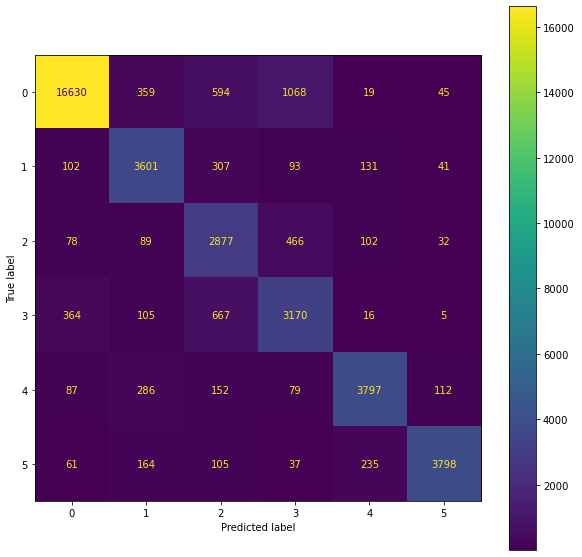

In [12]:
start = datetime.now()
predictions = model.predict(X_test_scaled)
end = datetime.now()

print("Prediction Time per Window: ", ((end-start).total_seconds()*1000)/predictions.shape[0])

acc, balanced_acc = evaluate_model(y_test, predictions)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [13]:
model.save(r"C:\Users\Hagar\Desktop\DNN Model\dnn_model")

INFO:tensorflow:Assets written to: C:\Users\Hagar\Desktop\DNN Model\dnn_model\assets
